# Sekwencyjny model CNN z Keras i własną Bazą Danych
W tym zeszycie używam własnej, przygotowanej wcześniej bazy obrazków do analizy.
Obrazki mogą być w dowolnym formacie, ale z przyzwyczajenia użyłem takiego samego jak w MNIST.
Tym razem jednak są w formacie PNG (mogą być i JPG), w skali szarości i ich procesowanie wyglądało nieco inaczej.
Jak przygotować zbiór danych piszę poniżej:

<Tu wstaw opis jak przygotowałeś zbiór danych jak już kod będzie działał poprawnie>

In [1]:
# Poniższy model daje nam jako takie pojęcie o tym w jaki sposób można przygotować niewielką ilość danych tak,
# aby model jednak się czegoś nauczył. W końcu nie zawsze mamy jakieś pół miliona rekordów. Ja dostałem powalającą
# ilość 150 case'ów ćwiczebnych, także trzeba było kombinować. Poniżej masz rezultat mojego bezczelnego zżyniania,
# optymalizowania i kombinowania. Enjoy. :P

# Oryginalny kod pożyczony w słusznej sprawie z: https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
#from keras.optimizers import SGD #Używam Adam, ale mogę chcieć użyć np. SGD

Using TensorFlow backend.


In [18]:
# Podajemy wymiary obrazka. Ja używam formatu takiego jak w MNIST, ale możesz mieć każdy inny...
img_width, img_height = 28, 28

num_classes = 10 # Ilość kategorii
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 150
nb_validation_samples = 80
epochs = 10
batch_size = 10
color_cha = 1 # Ilość kanałów. W Odcieniach szarości będziesz miał 1, W kolorze (RGB) będziesz miał 3.

# Ten fragment odczytuje z obrazków w jakim formacie są zapisane kanały kodowania kolorów.
if K.image_data_format() == 'channels_first':
    input_shape = (color_cha, img_width, img_height)
else:
    input_shape = (img_width, img_height, color_cha)

# Część główna modelu. W porównaniu do TF, Keras jest bardzo prosty. 
# Jak klocki lego układa się warstwa na warstwie.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), # Tutaj kernel = filtr. Tj. 'przesuwamy' tym naszym filtrem o kształcie 3x3 po obrazku.
                                         # Poczytaj albo najlepiej obejrzyj film o CNN, bo to trudno opisać słowami.:)
                                         # Sprowadza się to do wyciągnięcia z tego 'przesuwania' kolejnej macierzy z Iloczynem Skalarnym.
                                         # W ten sposób można znaleźć 'interesujące', tj. kluczowe elementy obrazka i zaoszczędzić
                                         # na mocy obliczeniowej, oraz godzinach pracy przy ręcznym obrabianiu baz danych... Ale naprawdę obejrzyj wizualizację. Warto.
                 activation='relu',  # Wszyscy raczej zgadzają się, że Relu w warstwach ukrytych jest najpopularniejszy do aktywacji, bo przyspiesza uczenie.
                 input_shape=input_shape))
# Tutaj zauważ zmianę względem poprzedniego modelu.
model.add(Conv2D(64, (3, 3), activation='relu')) # W następnym już nie definiuję słownie kernel_size = (x,y), ale wiadomo ocb.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Pokombinuj z wartościami 'dropout'. Raczej zaczynaj od mniejszych i zwiększaj z czasem.
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Nie dawaj wyższych wartości końcowych 'dropout' niż 0.5, chyba, że wiesz co robisz...
# Sposób aktywacji ostatniej warstwy inny niż na przykładzie wyjściowym, 
# bo mam 10 kategorii, więc lepiej wziąć softmax.
model.add(Dense(num_classes, activation='softmax'))

                    # Sposób kalkulowania straty. Inny niż w przykładzie z którego brałem kod, bo mam aż 10 kategorii.
model.compile(loss='categorical_crossentropy',
              #Tutaj warto poeksperymentować z metodą optymalizacji:
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [19]:
### Preprocesowanie obrazków z TF Keras: https://keras.io/preprocessing/image/ ###

# Konfiguracja preprocesująca, której używamy do treningu.
train_datagen = ImageDataGenerator(
# obowiązkowe przeskalowanie (Normalizacja) z obowiązkowej skali int 0-225 na float32 0-1
    rescale = 1. / 255,
    rotation_range = 4, # W stopniach. Losowo obraca obrazki o tyle stopni.
    # Przycięcie obrazka do wartości zbliżenia.
     shear_range = 0.2,
    # Powiększenie obrazka o wartość przycięcia.
    zoom_range = 0.2,
    )
# Jakbyśmy mieli np. obrazki psów i kotów, albo samochodów, to można je jeszcze np. przerzucić w pionie. 
# W wypadku pewnych zbiorów danych jak np. litery, cyfry itp. znaki, to jest imho wątpliwe ;)
# Kod przerzucający poniżej: horizontal_flip=True. Wrzuć wraz z resztą w nawias. 
# Więcej i pomocy tricków znajdziesz w Zakładce ImageDataGenerator w linku u góry.
# Jak to odpowiednio rozbujać, to wygląda jakbyśmy chcieli zafundować maszynie halucynacje... :]

# Konfiguracja preprocesująca, której użyjemy do walidacji i testów:
# Tylko przeskalowanie nasycenia z int na float.
test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',  # Obrazki są w skali szarości. Jak tego nie damy, to model przyjmie, że są w RGB.
    class_mode='categorical') # Typ klasyfikacji. Tutaj zwraca nam 10 typu one-hot.

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='categorical')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
    
model.save_weights('first_try.h5')

Found 150 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
Epoch 1/10
15/15 [==============================] - 5s 363ms/step - loss: 1.9090 - acc: 0.3563 - val_loss: 1.0370 - val_acc: 0.7812
Epoch 2/10
15/15 [==============================] - 3s 202ms/step - loss: 0.9808 - acc: 0.6890 - val_loss: 0.4661 - val_acc: 0.9038
Epoch 3/10
15/15 [==============================] - 3s 199ms/step - loss: 0.5564 - acc: 0.8097 - val_loss: 0.2375 - val_acc: 0.9423
Epoch 4/10
15/15 [==============================] - 3s 202ms/step - loss: 0.4550 - acc: 0.8357 - val_loss: 0.1445 - val_acc: 0.9911
Epoch 5/10
15/15 [==============================] - 3s 201ms/step - loss: 0.3782 - acc: 0.8916 - val_loss: 0.0915 - val_acc: 0.9856
Epoch 6/10
15/15 [==============================] - 3s 204ms/step - loss: 0.2400 - acc: 0.9119 - val_loss: 0.0584 - val_acc: 0.9856
Epoch 7/10
15/15 [==============================] - 3s 201ms/step - loss: 0.2385 - acc: 0.9152 - val_loss: 0.0539 - val_acc: 

## Wizualizacja uczenia się modelu
Zobaczymy czy, na ile i w którym miejscu mamy overfitting

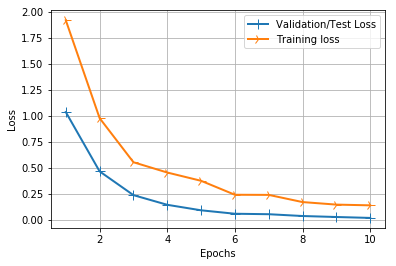

In [20]:
import matplotlib.pyplot as plt
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
#Poniżej funkcja straty w czasie dla powyższego modelu. Imho całkiem w porządku.

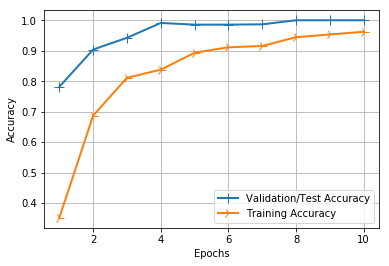

In [21]:
import matplotlib.pyplot as plt
history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
# Poniżej trafność w czasie dla powyższego modelu.

## Zapisujemy nasz model
Zmień na pełną ścieżkę docelową na swoim komputerze.
Uważaj, żeby folder faktycznie istniał, bo program nie stworzy ścieżek automatycznie.

In [24]:
model.save("/home/SpookyProgrammer/tensorxp/git/ai/research_process/trainedmodels/simple_chars_10.h5")
print('Model Saved')

Model Saved
